In [1]:
import numpy as np
import energyflow
from particle import Particle

import torch
import torch.nn as nn
import pennylane as qml
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import to_networkx
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, L1Loss
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm


import networkx as nx
import os
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
n_connections = 8
input_dims = 8
hidden_dims = [32,16,8]
output_dims = 4
q_depth = 1
epochs = 20
lr = 1e-3
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 1000

In [3]:
X = np.load(r'../data/qg_graph/x10_sorted_12500.npy')
y = np.load(r'../data/qg_graph/y10_sorted_12500.npy')
N=12500

In [4]:
def preprocess_fixed_nodes(x_data,y_data,nodes_per_graph=10): #,masses):
    print('--- Finding All Unique Particles ---')
    unique_particles = np.unique(x_data[:,:,3])
    x_data = torch.tensor(x_data)
    y_data = torch.tensor(y_data)
    print()
    print('--- Inserting Masses ---')
    masses = torch.zeros((x_data.shape[0],x_data.shape[1]))
    for i,particle in tqdm(enumerate(unique_particles)):
        if particle!=0:
            mass = Particle.from_pdgid(particle).mass/1000
            inds = torch.where(particle==x_data[:,:,3])
            masses[inds]=mass # GeV
    print()
    print('--- Calculating Momenta and Energies ---')
    #theta = torch.arctan(torch.exp(-X[:,:,1]))*2 # polar angle
    pt        = x_data[:,:,0]     # transverse momentum
    rapidity  = x_data[:,:,1]     # rapidity
    phi       = x_data[:,:,2]     # azimuthal angle
    
    mt        = (pt**2+masses**2).sqrt() # Transverse mass
    energy    = mt*torch.cosh(rapidity) # Energy per multiplicity bin
    e_per_jet = energy.sum(axis=1)  # total energy per jet summed across multiplicity bins

    px = pt*torch.cos(phi)  # momentum in x
    py = pt*torch.sin(phi)  # momentum in y
    pz = mt*torch.sinh(rapidity)  # momentum in z
    
    # three momentum
    p  = torch.cat(( px[:,:,None],  
                     py[:,:,None],
                     pz[:,:,None]), dim=2 )

    p_per_jet        = (p).sum(axis=1)  # total componet momentum per jet
    pt_per_Mbin      = (p_per_jet[:,:2]**2).sum(axis=1).sqrt()  # transverse momentum per jet
    mass_per_jet     = (e_per_jet**2-(p_per_jet**2).sum(axis=1)).sqrt() # mass per jet
    rapidity_per_jet = torch.log( (e_per_jet+p_per_jet[:,2])/(e_per_jet-p_per_jet[:,2]) )/2  # rapidity per jet from analytical formula
    end_multiplicity_indx_per_jet = (pt!=0).sum(axis=1).int() # see where the jet (graph) ends
    
    x_data = torch.cat( ( x_data[:,:,:3],
                          x_data[:,:,4:],
                          masses[:,:,None],
                          energy[:,:,None],
                          p), dim=2)
    
    x_data_max = (x_data.max(dim=1).values).max(dim=0).values
    x_data = x_data/x_data_max

    print()
    print('--- Calculating Edge Tensors ---')
    N = x_data[:,0,3].shape[0]  # number of jets (graphs)
    M = nodes_per_graph #x_data[0,:,3].shape[0]  # number of max multiplicty
    connections = nodes_per_graph
    edge_tensor = torch.zeros((N,M,M))
    edge_indx_tensor = torch.zeros((N,2,connections*(connections-1) )) # M*(connections-1) is the max number of edges we allow per jet
    edge_attr_matrix = torch.zeros((N,connections*(connections-1),1)) 
#     fixed_edges_list = torch.tensor([ [i,j] for i in range(connections) for j in range(connections) if i!=j]).reshape(2,90)
    
    for jet in tqdm(range(N)):
        stop_indx = end_multiplicity_indx_per_jet[jet] #connections # stop finding edges once we hit zeros -> when we hit 10
        if end_multiplicity_indx_per_jet[jet]>=connections:
            for m in range(connections):
#                 inds_edge = np.argsort((energy[jet,m]+energy[jet,:stop_indx])**2-torch.sum((p[jet,m,:stop_indx]+p[jet,:stop_indx,:])**2,axis=1))[:connections]
#                 edge_tensor[jet,m,:] = (energy[jet,m]+energy[jet,:connections])**2-torch.sum((p[jet,m,:]+p[jet,:connections,:])**2,axis=1)
#                 edge_tensor[jet,m,m] = 0.
#                 edge_tensor[jet,m,m]=((energy[jet,m]+energy[jet,m])**2-torch.sum((p[jet,m,:]+p[jet,m,:])**2,axis=0))
                # inds_edge = torch.sqrt( (phi[jet,m]-phi[jet,:])**2 + (rapidity[jet,m]-rapidity[jet,:])**2 ).argsort()[:connections]
                # edge_tensor[jet,m,:] = torch.sqrt( (phi[jet,m]-phi[jet,inds_edge])**2 + (rapidity[jet,m]-rapidity[jet,inds_edge])**2 )
                edge_tensor[jet,m,:] = torch.sqrt( (phi[jet,m]-phi[jet,:connections])**2 + (rapidity[jet,m]-rapidity[jet,:connections])**2 )
#                 inds_edge = np.argsort( (energy[jet,m]+energy[jet,:stop_indx])**2-torch.sum((p[jet,m,:stop_indx]+p[jet,:stop_indx,:])**2,axis=1) )[:connections]
#                 edge_tensor[jet,m,inds_edge] = (energy[jet,m]+energy[jet,inds_edge])**2-torch.sum((p[jet,m,:]+p[jet,inds_edge,:])**2,axis=1)
            edges_exist_at = torch.where(edge_tensor[jet,:,:].abs()>0)
            
#             edge_indx_tensor[jet,:,:(edge_tensor[jet,:,:].abs()>0).sum()] = fixed_edges_list 
            edge_indx_tensor[jet,:,:(edge_tensor[jet,:,:].abs()>0).sum()] = torch.cat((edges_exist_at[0][None,:],edges_exist_at[1][None,:]),dim=0).reshape((2,edges_exist_at[0].shape[0]))   
            edge_attr_matrix[jet,:(edge_tensor[jet,:,:].abs()>0).sum(),0]  =  edge_tensor[jet,edges_exist_at[0],edges_exist_at[1]].flatten()

    end_edges_indx_per_jet = (edge_attr_matrix!=0).sum(axis=1).int()
    keep_inds =  torch.where(end_edges_indx_per_jet>=connections)[0]
    
    edge_tensor = edge_tensor/edge_tensor.max()
    edge_attr_matrix = edge_attr_matrix/edge_attr_matrix.max()
    
    graph_help = torch.cat( ( (energy.max(axis=1).values/e_per_jet).reshape(x_data[:,0,3].shape[0],1),
                              (mass_per_jet).reshape(x_data[:,0,3].shape[0],1),
                              (end_multiplicity_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int(),
                              (end_edges_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int() ), dim=1)
        
    return x_data[keep_inds,:nodes_per_graph], y_data[keep_inds].long(), edge_tensor[keep_inds], edge_indx_tensor[keep_inds].long(), edge_attr_matrix[keep_inds], graph_help[keep_inds]



In [5]:
x_data, y_data, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(X,y)

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 380.77it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:23<00:00, 533.53it/s]


In [6]:
print('----- Check for the correctly sized tensors -----')
print()
print(f'Jet Data: {x_data.shape}')
print(f'Classification: {y_data.shape}')
print(f'Full Edge Information: {edge_tensor.shape}')
print(f'Edge Index Information: {edge_indx_tensor.shape}')
print(f'Edge Attribute Information: {edge_attr_matrix.shape}')
print(f'Graph Structure Information: {graph_help.shape}')
print('\n')
print('----- Check that each tensor is normalized -----')
print()
print(f'Jet Data max: {torch.max(x_data)}')
print(f'Classification Max: {torch.max(y_data)}')
print(f'Edge Length Max: {torch.max(edge_tensor)}')

----- Check for the correctly sized tensors -----

Jet Data: torch.Size([12500, 10, 8])
Classification: torch.Size([12500])
Full Edge Information: torch.Size([12500, 10, 10])
Edge Index Information: torch.Size([12500, 2, 90])
Edge Attribute Information: torch.Size([12500, 90, 1])
Graph Structure Information: torch.Size([12500, 4])


----- Check that each tensor is normalized -----

Jet Data max: 1.0
Classification Max: 1
Edge Length Max: 1.0


In [7]:
print('----- Check the structure of the dataset -----')
print()
print(f'Number of graphs (jets): {x_data.shape[0]}')
print(r'Number of features per node (p_T(M),y,phi,m,E,px,py,pz): '+f'{x_data.shape[2]}')
print(f'Number of classes (2: Quarks or Gluons): {np.unique(y_data).shape[0]}')
print()
print('----- Check the structure of one graph -----')
print()
i=0
number_of_edges = graph_help[i,3]
# Gather some statistics about the first graph.
print(f'Number of nodes (particle IDs): {x_data[i,:,0].shape[0]}')
print(f'Number of edges: {number_of_edges}')
print(f'Average node degree: {number_of_edges / x_data[i,:,0].shape[0]:.2f}')
print(f'Is undirected: {True}')

----- Check the structure of the dataset -----

Number of graphs (jets): 12500
Number of features per node (p_T(M),y,phi,m,E,px,py,pz): 8
Number of classes (2: Quarks or Gluons): 2

----- Check the structure of one graph -----

Number of nodes (particle IDs): 10
Number of edges: 90.0
Average node degree: 9.00
Is undirected: True


In [8]:
# Create a dataset class
class Create_Dataset(Dataset):
    def __init__(self, edge_index, x, edge_attr, y, graph_info, transform=None):
        self.edge_index = edge_index
        self.x          = x
        self.edge_attr  = edge_attr
        self.y          = y
        self.graph_info = graph_info
        self.transform  = transform

    def __len__(self):
        return self.y.shape[0]

    # Could also just define an x,y,z then pass these variables
    # in the training functions over the loop for batch (actually think that way is easier to read)
    def __getitem__(self, index):
        sample = {'edge_index': self.edge_index[index,:,:self.graph_info[index,3]],
                'x': self.x[index,:int(self.graph_info[index,2]),:],
                'edge_attr': self.edge_attr[index,:self.graph_info[index,3]],
                'y': self.y[index] }

        if self.transform is not None:
            sample = self.transform(sample)
        return sample

In [9]:
train_index   = int(N*0.8)
val_index    = int(N*0.9)

# Create Datasets for Torch for the training and testing pahses
dataset = []
for i in tqdm(range(N)):
#     dataset.append(Data(edge_index=edge_indx_tensor[i,:,:int(graph_help[i,3])],x=x_data_proc[i,:int(graph_help[i,2]),:],edge_attr=edge_attr_matrix[i,:int(graph_help[i,3])],y=y_data_proc[i]))
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:],
                        x=x_data[i,:,:],
                        edge_attr=edge_attr_matrix[i,:],
                        y=y_data[i]))

original_dataset = dataset

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 8455.80it/s]


In [10]:
import torch
from torch_geometric.utils import subgraph

# Function to randomly drop nodes in a graph
def drop_nodes(data, drop_prob=0.2):
    node_mask = torch.rand(data.x.size(0)) > drop_prob
    data.x = data.x[node_mask]
    data.edge_index, _ = subgraph(node_mask, data.edge_index, relabel_nodes=True)
    return data

# Function to randomly drop edges in a graph
def drop_edges(data, drop_prob=0.2):
    edge_mask = torch.rand(data.edge_index.size(1)) > drop_prob
    data.edge_index = data.edge_index[:, edge_mask]
    return data

# Function to randomly mask node features in a graph
def mask_features(data, mask_prob=0.2):
    feature_mask = torch.rand(data.x.size()) > mask_prob
    data.x = data.x * feature_mask.float()
    return data

In [11]:
import random
from torch_geometric.data import Data
from collections import defaultdict

# Define the augmentation function
def graph_augment(data):
    # Example augmentation: randomly drop nodes, edges, and mask features
    data_aug = data.clone()
    data_aug = drop_nodes(data_aug, drop_prob=0.1)
    # data_aug = drop_edges(data_aug, drop_prob=0.1)
    data_aug = mask_features(data_aug, mask_prob=0.1)
    return data_aug

def create_contrastive_pairs(dataset):
    pairs = []
    labels = []

    # Group graphs by their labels (0 or 1)
    label_to_graphs = defaultdict(list)
    for data in dataset:
        label_to_graphs[data.y.item()].append(data)

    # Create pairs for positive class
    for data in label_to_graphs[1]:  # For each positive graph
        data_aug = graph_augment(data)  # Create an augmented version
        pairs.append((data, data_aug))  # Add the original and augmented graph as a pair
        labels.append(1)  # Label 1 for positive pair (similar)

    # Create pairs for negative class
    for data in label_to_graphs[0]:  # For each negative graph
        data_aug = graph_augment(data)  # Create an augmented version
        pairs.append((data, data_aug))  # Add the original and augmented graph as a pair
        labels.append(0)  # Label 0 for negative pair (dissimilar)

    return pairs, labels


In [12]:
pairs, labels = create_contrastive_pairs(dataset)

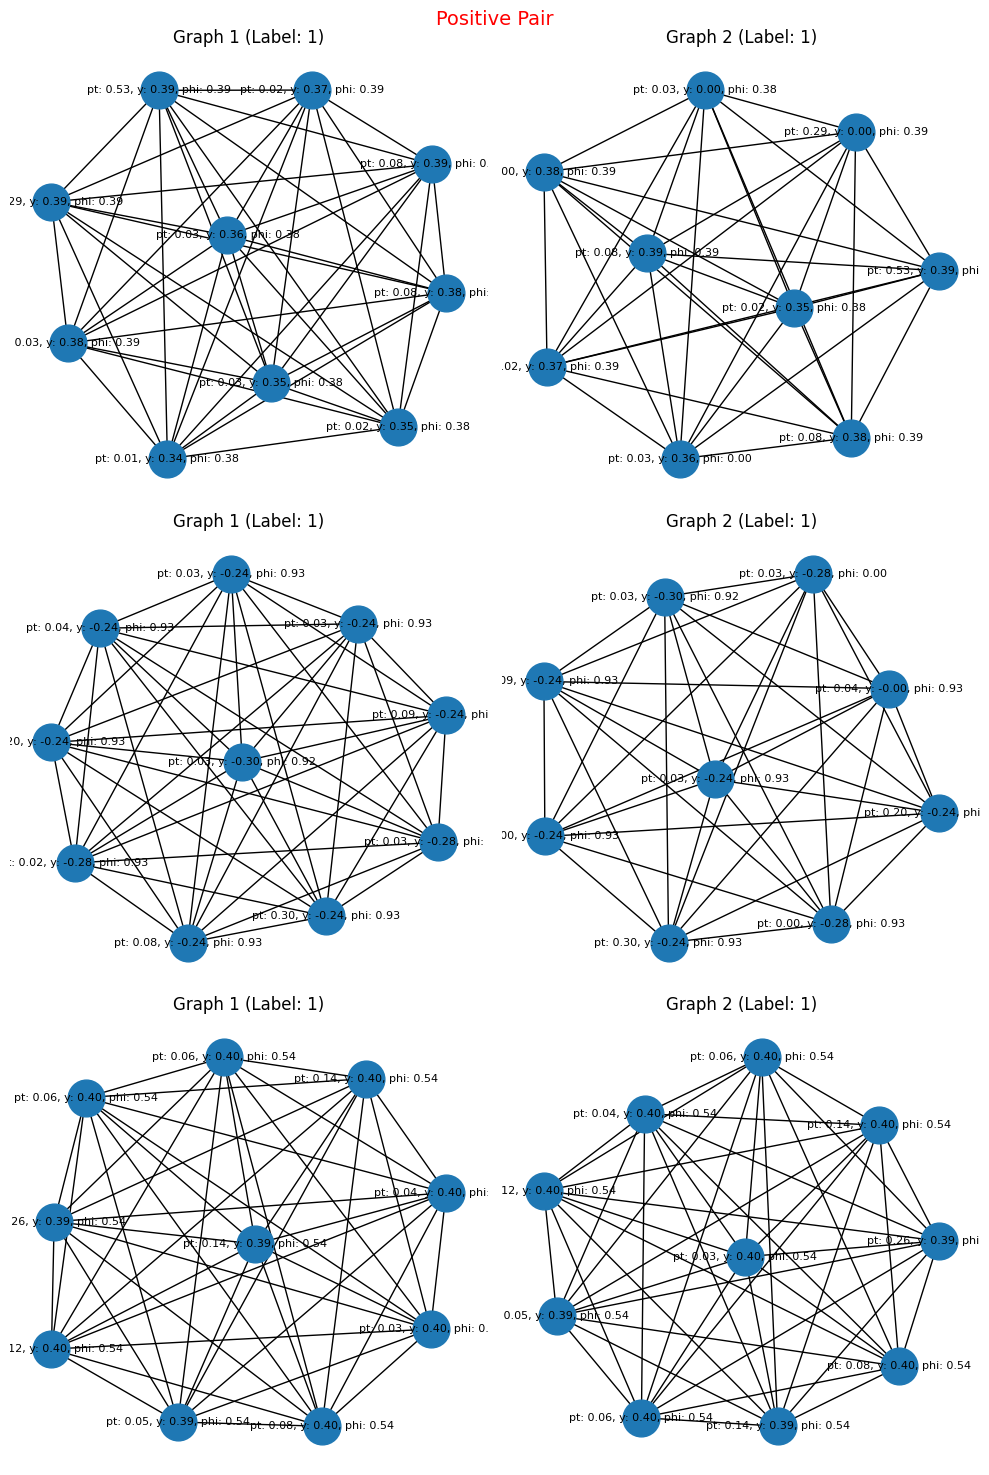

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph_pairs(pairs, labels, num_pairs=3):
    plt.figure(figsize=(10, 5 * num_pairs))
    
    for i, (data1, data2) in enumerate(pairs[:num_pairs]):
        # Create a subplot for each pair
        plt.subplot(num_pairs, 2, 2 * i + 1)
        
        # Convert both graphs to NetworkX format for visualization
        G1 = to_networkx(data1, to_undirected=True)
        node_labels_1 = {j: f"pt: {data1.x[j][0]:.2f}, y: {data1.x[j][1]:.2f}, phi: {data1.x[j][2]:.2f}" 
                         for j in range(data1.x.size(0))}
        
        nx.draw(G1, with_labels=True, labels=node_labels_1, node_size=700, font_size=8)
        plt.title(f"Graph 1 (Label: {data1.y.item()})")

        plt.subplot(num_pairs, 2, 2 * i + 2)
        G2 = to_networkx(data2, to_undirected=True)
        node_labels_2 = {j: f"pt: {data2.x[j][0]:.2f}, y: {data2.x[j][1]:.2f}, phi: {data2.x[j][2]:.2f}" 
                         for j in range(data2.x.size(0))}
        
        nx.draw(G2, with_labels=True, labels=node_labels_2, node_size=700, font_size=8)
        plt.title(f"Graph 2 (Label: {data2.y.item()})")

        pair_type = "Positive Pair" if labels[i] == 1 else "Negative Pair"
        plt.suptitle(pair_type, fontsize=14, color='red')

    plt.tight_layout()
    plt.show()

visualize_graph_pairs(pairs, labels, num_pairs=3)

In [14]:
# training_data = dataset[:train_index]
# val_data      = dataset[train_index:val_index]
# test_data     = dataset[val_index:]

# # Create data loaders
# train_dataloader = DataLoader(training_data,
#                               batch_size = batch_size,
#                               shuffle = True,
#                               num_workers = 0)

# val_dataloader  = DataLoader(val_data,
#                               batch_size = batch_size,
#                               shuffle = False,
#                               num_workers = 0)

# test_dataloader  = DataLoader(test_data,
#                               batch_size = batch_size,
#                               shuffle = False,
#                               num_workers = 0)

# print(f'Number of training graphs: {train_index}')
# print(f'Number of validation graphs: {val_index-train_index}')
# print(f'Number of test graphs: {N-val_index}')

In [15]:
from torch.utils.data import Dataset

class GraphPairDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs  # List of (graph1, graph2) tuples
        self.labels = labels  # List of similarity labels (0 or 1)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        graph1, graph2 = self.pairs[idx]
        label = self.labels[idx]
        return graph1, graph2, label


In [16]:
import torch
from sklearn.model_selection import train_test_split

def split_pairs(pairs, labels, train_ratio, val_ratio):
    # Split train and temporary (val + test)
    train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
        pairs, labels, train_size=train_ratio, random_state=42, stratify=labels
    )
    
    # Split validation and test from the temporary set
    val_pairs, test_pairs, val_labels, test_labels = train_test_split(
        temp_pairs, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    return train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels

# Assuming pairs and labels are created using create_contrastive_pairs()
# pairs, labels = create_contrastive_pairs(dataset)  # Create pairs for the entire dataset

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split the pairs into training, validation, and test sets
train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels = split_pairs(
    pairs, labels, train_ratio, val_ratio
)

In [17]:
# Now, create datasets and dataloaders for each split
train_dataset = GraphPairDataset(train_pairs, train_labels)
val_dataset = GraphPairDataset(val_pairs, val_labels)
test_dataset = GraphPairDataset(test_pairs, test_labels)

batch_size = 1000

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [18]:
train_dataset[0][0].edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4, 5, 6,
         7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2,
         3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 8, 9,
         0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [19]:
train_dataset[0][1].edge_index

tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
         4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6],
        [1, 2, 3, 4, 5, 6, 0, 2, 3, 4, 5, 6, 0, 1, 3, 4, 5, 6, 0, 1, 2, 4, 5, 6,
         0, 1, 2, 3, 5, 6, 0, 1, 2, 3, 4, 6, 0, 1, 2, 3, 4, 5]])

In [20]:
train_dataset[0]

(Data(x=[10, 8], edge_index=[2, 90], edge_attr=[90, 1], y=1),
 Data(x=[7, 8], edge_index=[2, 42], edge_attr=[90, 1], y=1),
 1)

In [21]:
# Check a sample from the dataloader
for data1, data2, label in train_dataloader:
    print(data1)
    print(data2)
    print(label)
    break

DataBatch(x=[10000, 8], edge_index=[2, 90000], edge_attr=[90000, 1], y=[1000], batch=[10000], ptr=[1001])
DataBatch(x=[8961, 8], edge_index=[2, 72272], edge_attr=[90000, 1], y=[1000], batch=[8961], ptr=[1001])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,

In [22]:
from torch_geometric.nn import GATConv, global_mean_pool, GraphConv
from torch.nn import ModuleList, Linear, ReLU
import torch


class GNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn):
        super().__init__()
        layers = []
        layers.append(GATConv(input_dims, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.readout_layer = Linear(hidden_dims[-1], output_dims)  # No final classifier, just embeddings
        self.dropout = torch.nn.Dropout(p=0.5)  # Add dropout to layers


    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
            h = self.dropout(h)  # Apply dropout
         
        h = global_mean_pool(h, batch)   # Readout layer to get the embedding for each graph in batch
        return h  # Return the graph embeddings

In [31]:
def run_model(model, epoch, dataloader, lossFn, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    num_samples = 0

    for batch in dataloader:
        optimizer.zero_grad() if train else None

        # Extract the pairs and labels from the dataloader batch
        data1, data2, labels = batch[0], batch[1], batch[2]
        
        # Get the embeddings for both graphs
        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)
        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)
        
        # Compute contrastive loss
        loss = lossFn(emb1, emb2)  # Now the labels are passed explicitly
        
        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        num_samples += data1.num_graphs

        # Compute accuracy
    #     with torch.no_grad():
    #         cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
    #         predictions = (cos_sim > 0.5).long()  # You can adjust the threshold
    #         # correct = (predictions == labels.to(self.device)).sum().item()
    #         correct += (predictions == labels).sum().item()
    #         total = labels.size(0)

    avg_loss = total_loss / num_samples
    # accuracy = correct / num_samples
    return avg_loss


In [35]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Run training
        train_loss = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        
        # Run validation
        val_loss = run_model(model, epoch, val_dataloader, lossFn, optimizer=None, train=False)
        
        # Print results
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Store loss and accuracy for this epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        # history['train_acc'].append(train_acc)
        # history['val_acc'].append(val_acc)
        
    return history


In [36]:
os.chdir('..');
print(os.getcwd())
from qssl.loss.losses import ContrastiveLoss

C:\Users\Sanya Nanda


In [37]:
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFn = ContrastiveLoss(margin=1, mode='pairs')  # Use contrastive loss in pair mode
history = train_model(model, optimizer, lossFn=lossFn, epochs=50, lr=0.001, train_dataloader=train_dataloader, val_dataloader=val_dataloader)


Epoch 1, Train Loss: 0.9414, Val Loss: 0.9669
Epoch 2, Train Loss: 0.8717, Val Loss: 0.9241
Epoch 3, Train Loss: 0.7437, Val Loss: 0.8470
Epoch 4, Train Loss: 0.5644, Val Loss: 0.7295
Epoch 5, Train Loss: 0.3710, Val Loss: 0.6070
Epoch 6, Train Loss: 0.2150, Val Loss: 0.5051
Epoch 7, Train Loss: 0.1145, Val Loss: 0.4257
Epoch 8, Train Loss: 0.0624, Val Loss: 0.3657
Epoch 9, Train Loss: 0.0359, Val Loss: 0.3237
Epoch 10, Train Loss: 0.0237, Val Loss: 0.2957
Epoch 11, Train Loss: 0.0176, Val Loss: 0.2776
Epoch 12, Train Loss: 0.0147, Val Loss: 0.2658
Epoch 13, Train Loss: 0.0128, Val Loss: 0.2579
Epoch 14, Train Loss: 0.0116, Val Loss: 0.2523
Epoch 15, Train Loss: 0.0110, Val Loss: 0.2480
Epoch 16, Train Loss: 0.0106, Val Loss: 0.2447
Epoch 17, Train Loss: 0.0102, Val Loss: 0.2423
Epoch 18, Train Loss: 0.0099, Val Loss: 0.2404
Epoch 19, Train Loss: 0.0097, Val Loss: 0.2386
Epoch 20, Train Loss: 0.0097, Val Loss: 0.2368
Epoch 21, Train Loss: 0.0094, Val Loss: 0.2351
Epoch 22, Train Loss: 

<Axes: title={'center': 'Learning History'}>

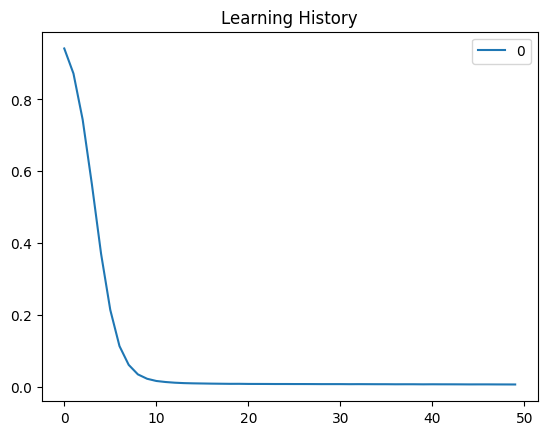

In [45]:
import pandas as pd
pd.DataFrame(history["train_loss"]).plot(title="Learning History")

<Axes: title={'center': 'Learning History (validation)'}>

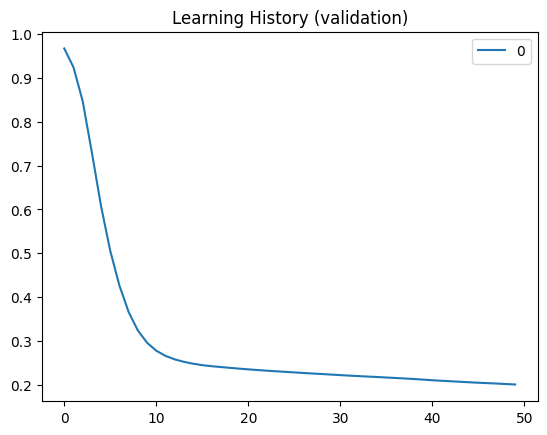

In [46]:
pd.DataFrame(history["val_loss"]).plot(title="Learning History (validation)")

In [47]:
### LCT

In [61]:
def run_model_lct(model, epoch, dataloader, lossFn, optimizer=None, train=True, return_embeddings=False):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    num_samples = 0
    all_embeddings = []
    all_labels = []

    for batch in dataloader:
        optimizer.zero_grad() if train else None

        # Extract the pairs and labels from the dataloader batch
        data1, data2, labels = batch[0], batch[1], batch[2]
        
        # Get the embeddings for both graphs
        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)
        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)
        
        if return_embeddings:
            # Save embeddings and labels for later use in classification
            all_embeddings.append(emb1.detach().cpu())
            all_labels.append(labels.detach().cpu())

        # Compute contrastive loss
        loss = lossFn(emb1, emb2)  # Now the labels are passed explicitly
        
        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        num_samples += data1.num_graphs

        # Compute accuracy
        with torch.no_grad():
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            predictions = (cos_sim > 0.5).long()  # You can adjust the threshold
            correct += (predictions == labels).sum().item()

    avg_loss = total_loss / num_samples
    accuracy = correct / num_samples

    if return_embeddings:
        return torch.cat(all_embeddings, dim=0), torch.cat(all_labels, dim=0)
    return avg_loss, accuracy


In [63]:
training_data = original_dataset[:train_index]
val_data      = original_dataset[train_index:val_index]
test_data     = original_dataset[val_index:]

# Create data loaders
train_loader = DataLoader(training_data,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0)

val_loader  = DataLoader(val_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

test_loader  = DataLoader(test_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

print(f'Number of training graphs: {train_index}')
print(f'Number of validation graphs: {val_index-train_index}')
print(f'Number of test graphs: {N-val_index}')

Number of training graphs: 10000
Number of validation graphs: 1250
Number of test graphs: 1250


In [64]:
# After training, use the run_model function to extract embeddings from the validation/test dataset
train_embeddings, train_labels = run_model_lct(model, epoch=0, dataloader=train_dataloader, lossFn=lossFn, return_embeddings=True, train=False)
test_embeddings, test_labels = run_model_lct(model, epoch=0, dataloader=test_dataloader, lossFn=lossFn, return_embeddings=True, train=False)

# Convert embeddings and labels to numpy arrays for scikit-learn
X_train = train_embeddings.cpu().numpy()
y_train = train_labels.cpu().numpy()
X_test = test_embeddings.cpu().numpy()
y_test = test_labels.cpu().numpy()

Linear Classifier Test Accuracy: 59.41%
AUC Score: 0.6375


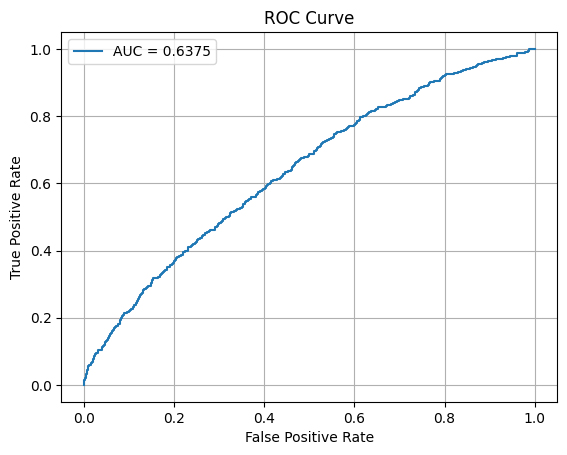

Confusion Matrix:
[[557 385]
 [376 557]]


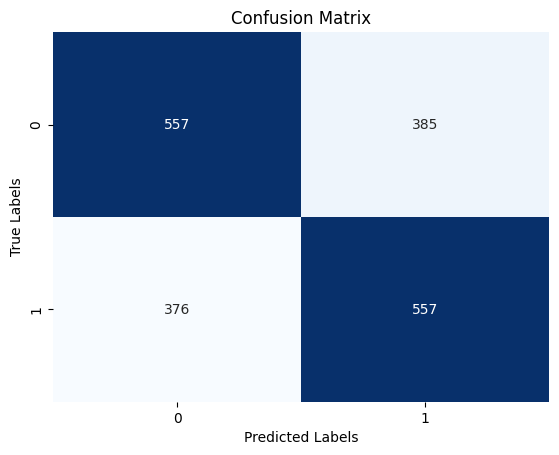

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Train a simple linear classifier (Logistic Regression in this case)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict on test set
y_pred = classifier.predict(X_test)

# Compute accuracy of the linear classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear Classifier Test Accuracy: {accuracy * 100:.2f}%")

# Compute the AUC score
# If y_test is multi-class, you might need to binarize it or use a one-vs-rest approach
if len(np.unique(y_test)) == 2:  # Binary classification
    y_prob = classifier.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"AUC Score: {auc_score:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, plot the confusion matrix
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [56]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# def plot_embeddings(embeddings, labels, method='pca'):
#     """
#     Plots the embeddings in 2D space after reducing the dimensions.
    
#     Parameters:
#     - embeddings: The high-dimensional embeddings.
#     - labels: The labels corresponding to each embedding (for coloring).
#     - method: 'pca' or 'tsne' for dimensionality reduction.
#     """
#     # Reduce embeddings to 2D
#     if method == 'pca':
#         reducer = PCA(n_components=2)
#         reduced_embeddings = reducer.fit_transform(embeddings)
#     elif method == 'tsne':
#         reducer = TSNE(n_components=2, random_state=42)
#         reduced_embeddings = reducer.fit_transform(embeddings)
#     else:
#         raise ValueError("Method must be 'pca' or 'tsne'.")

#     # Plot the embeddings
#     plt.figure(figsize=(8, 8))
#     scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='Spectral', alpha=0.8)
#     plt.colorbar(scatter)
#     plt.title(f"Embedding Visualization using {method.upper()}")
#     plt.xlabel("Component 1")
#     plt.ylabel("Component 2")
#     plt.grid(True)
#     plt.show()

# X_emb = train_embeddings.cpu().numpy()
# y_emb = train_labels.cpu().numpy()

# # Plot using PCA
# plot_embeddings(X_emb, y_emb, method='tsne')

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_auc(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data1, data2, labels in dataloader:
            emb1 = model(data1.x, data1.edge_index, data1.batch)
            emb2 = model(data2.x, data2.edge_index, data2.batch)
            distances = torch.sqrt(torch.sum((emb1 - emb2) ** 2, dim=1)).cpu().numpy()  # L2 distance
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            # predictions = (cos_sim > 0.5).long()
            y_scores.extend(cos_sim)
            y_true.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot AUC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data1, data2, labels in dataloader:
            emb1 = model(data1.x, data1.edge_index, data1.batch)
            emb2 = model(data2.x, data2.edge_index, data2.batch)
            # distances = torch.sqrt(torch.sum((emb1 - emb2) ** 2, dim=1))  # L2 distance
            # predictions = (distances < 0.5).cpu().numpy()  # Threshold of 0.5 for similarity

            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            predictions = (cos_sim > 0.5).long()
            
            y_pred.extend(predictions)
            y_true.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dissimilar", "Similar"])
    
    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [2]:
from sklearn.manifold import TSNE

def plot_embeddings(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for data1, data2, label in dataloader:
            emb1 = model(data1.x, data1.edge_index, data1.batch)
            emb2 = model(data2.x, data2.edge_index, data2.batch)
            embeddings.extend(emb1.cpu().numpy())
            embeddings.extend(emb2.cpu().numpy())
            labels.extend(label.cpu().numpy())
            labels.extend(label.cpu().numpy())  # Add labels for both graphs in the pair

    # Reduce dimensions for visualization (e.g., t-SNE)
    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
    
    # Plot embeddings
    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', s=10)
    plt.title("Graph Embeddings (t-SNE)")
    plt.colorbar()
    plt.show()


In [3]:
def print_pair_embeddings(model, dataloader, pair_index=0):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data1, data2, label = next(iter(dataloader))
        emb1 = model(data1.x, data1.edge_index, data1.batch)
        emb2 = model(data2.x, data2.edge_index, data2.batch)
        
        print(f"Embeddings for pair {pair_index}:")
        print("Embedding 1:", emb1)
        print("Embedding 2:", emb2)
        print("Label:", label)
